In [1]:
!pip install Biopython
!pip install wordcloud
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!python -m spacy download en_core_web_sm

import pandas as pd
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from pprint import pprint
from gensim.models import CoherenceModel
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-31 22:39:32.978180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 22:39:34.685176: W tensorflow/compiler/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df=pd.read_csv('uc2_all_pmids.csv')
df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PMID
0,30871490
1,29728073
2,34177954
3,29898756
4,32978904
...,...
125,29973188
126,30428928
127,31536189
128,32337494


In [3]:
lists=df['PMID'].tolist()
len(lists)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


130

In [4]:
from Bio import Entrez

Entrez.email = 'your_email@provider.com'

pmids = lists
handle = Entrez.efetch(db="pubmed", id=','.join(map(str, pmids)),
                       rettype="xml", retmode="text")
records = Entrez.read(handle)


abstract=[]
noma=0
n=0
for pubmed_article in records['PubmedArticle']:
  n=n+1           
  try:
    abstract.append(pubmed_article['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
  except: 
    # abstract.append('\nno abstracts available.\n')
    noma=noma+1
    continue
    


# abstract_dict = dict(zip(pmids, abstracts))
abstract


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[StringElement('Breast cancer is the most common cancer in women worldwide, with a great diversity in outcomes among individual patients. The ability to accurately predict a breast cancer outcome is important to patients, physicians, researchers, and policy makers. Many models have been developed and tested in different settings. We systematically reviewed the prognostic models developed and/or validated for patients with breast cancer.', attributes={'Label': 'BACKGROUND', 'NlmCategory': 'BACKGROUND'}),
 StringElement('Neuroendocrine carcinoma of the cervix (NECC) is a rare variant of cervical cancer. The prognosis of women with NECC is poor and there is no standardized therapy for this type of malignancy based on controlled trials.', attributes={'Label': 'BACKGROUND', 'NlmCategory': 'BACKGROUND'}),
 'Gastric cancer is a leading cause of cancer-related deaths with considerable heterogeneity among patients. Appropriate classifications are essential for prognosis prediction and individua

In [5]:
print(len(abstract))
print(noma)
print(n)

129
0
129


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
with open("stopwords.txt", "r") as f:
    sw = f.read().split()
    
for w in range(0,len(sw)):
  sw[w]=sw[w].strip()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
abstract_=abstract.copy()
# abstract_

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize

def lemmatize_and_remove_stopwords(sentence,ssww):

  lemmat=WordNetLemmatizer()

  stopWords = nltk.corpus.stopwords.words('english')
  extra = ssww
  stopWords.extend(extra)

  filtered_list = []
  stop_words = stopWords
  words = word_tokenize(sentence)
  for w in words:
      if w.lower() not in stop_words:
          filtered_list.append(lemmat.lemmatize(w))         

  return " ".join(filtered_list)

for x in range(0,len(abstract_)):
  abstract_[x]=re.sub(r'\b[A-Z]+[0-9]*s?\b','', abstract_[x])
  abstract_[x]=re.sub(r'[\(\[].*?[\)\]]','', abstract_[x])
  abstract_[x]=abstract_[x].lower()
  abstract_[x]=re.sub(r'attributes=.*}','',abstract_[x])
  abstract_[x]=re.sub(r'StringElement','',abstract_[x])
  abstract_[x]=re.sub(r'\(.{0,5}\)','',abstract_[x])
  abstract_[x]=re.sub(r'[^\w\s]','',abstract_[x])
  abstract_[x]=re.sub(r'[0-9]',' ',abstract_[x])
  abstract_[x]=re.sub(r'(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', abstract_[x])
  # abstract_[x]=re.sub(r'[a-z]+[^\w]+',' ',abstract_[x])
  abstract_[x]=re.sub(r'\xa0.*',' ',abstract_[x])
  abstract_[x]=lemmatize_and_remove_stopwords(abstract_[x],sw)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
abstract_

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['breast common woman worldwide great diversity outcome individual patient ability accurately predict breast important patient researcher policy maker model developed tested setting systematically reviewed prognostic model developed validated patient breast',
 'neuroendocrine carcinoma cervix rare variant cervical prognosis woman poor standardized therapy malignancy based controlled trial',
 'gastric leading cause cancerrelated death considerable heterogeneity patient classification essential prognosis prediction individualized immunotherapy potential efficacy portion patient gastric study tried classify gastric specifically based immune signature established subtype cluster low medium high enrichment immune signature based immunogenomic profiling validated classification multiple independent datasets subsub subtype exhibited prognosis feature hot tumor low tumor purity high stromal component overexpression immune checkpoint molecule enriched tumorinfiltrated immune cell addition subsu

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = abstract_
data_words = list(sent_to_words(data))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
dictionary = gensim.corpora.Dictionary(data_words)
bow_corpus = [dictionary.doc2bow(doc) for doc in data_words]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_values= []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=num_topics,random_state=100,update_every=1,passes=10,alpha='auto',per_word_topics=True,)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))


    return model_list, coherence_values, perplexity_values

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=data_words, start=10, limit=100, step=20)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


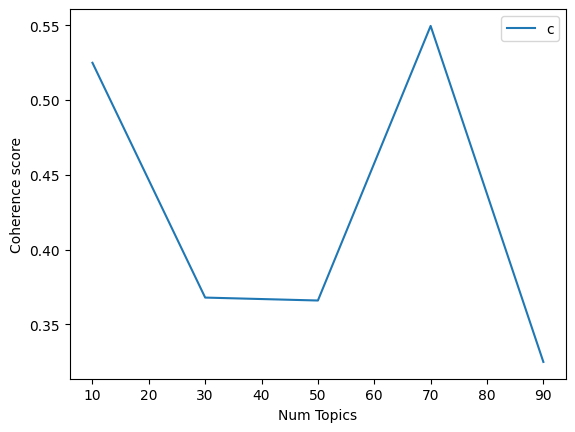

In [14]:
# Show graph
import matplotlib.pyplot as plt

limit=100; start=10; step=20;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.525
Num Topics = 30  has Coherence Value of 0.3679
Num Topics = 50  has Coherence Value of 0.3659
Num Topics = 70  has Coherence Value of 0.5496
Num Topics = 90  has Coherence Value of 0.3248


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


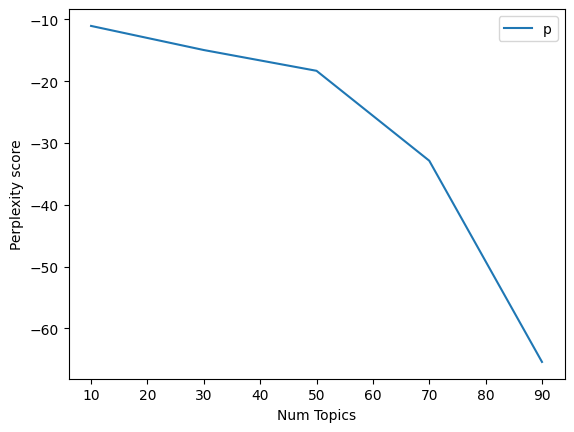

In [16]:
limit=100; start=10; step=20;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [17]:
for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " has perplixity Value of", round(cv, 4))

Num Topics = 10  has perplixity Value of -11.0534
Num Topics = 30  has perplixity Value of -14.9562
Num Topics = 50  has perplixity Value of -18.3177
Num Topics = 70  has perplixity Value of -32.8718
Num Topics = 90  has perplixity Value of -65.4383


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                            )

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus_tfidf]

[(0,
  '0.006*"pancreatic" + 0.005*"pembrolizumab" + 0.004*"colorectal" + '
  '0.004*"ki" + 0.004*"rebiopsy" + 0.004*"gemcitabine" + 0.004*"ductal" + '
  '0.004*"adenocarcinoma" + 0.003*"firstline" + 0.003*"lynch"'),
 (1,
  '0.004*"breast" + 0.004*"fluid" + 0.004*"adenoma" + 0.004*"patient" + '
  '0.004*"advanced" + 0.004*"extensivestage" + 0.004*"dosedense" + '
  '0.004*"chemotherapy" + 0.004*"inhibitor" + 0.003*"benefit"'),
 (2,
  '0.005*"radical" + 0.005*"apps" + 0.004*"postoperative" + 0.004*"screening" '
  '+ 0.004*"ligation" + 0.004*"tumor" + 0.003*"topic" + 0.003*"telomere" + '
  '0.003*"participant" + 0.003*"program"'),
 (3,
  '0.006*"prognosis" + 0.005*"mir" + 0.005*"breast" + 0.005*"mirna" + '
  '0.004*"acute" + 0.004*"analysis" + 0.004*"mutation" + 0.004*"marker" + '
  '0.004*"gastric" + 0.004*"prognostic"'),
 (4,
  '0.006*"radiotherapy" + 0.004*"colorectal" + 0.004*"haemoglobin" + '
  '0.003*"intervention" + 0.003*"surgery" + 0.003*"identify" + '
  '0.003*"packaging" + 0.00

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -11.053421405106972

Coherence Score:  0.5249637282669718


In [22]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dictionary)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.041003 -0.022287       1        1  12.732369
1     -0.014941  0.031756       2        1  12.098625
4     -0.039596 -0.033135       3        1  11.986913
0      0.005153  0.012360       4        1  11.149037
9      0.001619  0.007803       5        1  10.534895
8      0.015048 -0.000018       6        1  10.426792
6     -0.004027 -0.001336       7        1   8.265282
2     -0.000583  0.000907       8        1   7.976680
7     -0.003151  0.000967       9        1   7.716485
5     -0.000525  0.002983      10        1   7.112921, topic_info=                Term      Freq     Total Category  logprob  loglift
890     radiotherapy  0.000000  0.000000  Default  30.0000  30.0000
1103   esophagectomy  0.000000  0.000000  Default  29.0000  29.0000
1255  transformation  0.000000  0.000000  Default  28.0000  28.0000
825          radical  0.000000  0.000000  Default  27.0000  27.0000
612       pancreatic  0.000000  0.000000  Default  26.0000  26.0000
...              ...       ...       ...      ...      ...      ...
384        published  0.083323  0.451841  Topic10  -6.1280   0.9527
107            study  0.096694  0.982708  Topic10  -5.9792   0.3245
229           impact  0.087826  0.703617  Topic10  -6.0754   0.5624
36             trial  0.087773  0.723751  Topic10  -6.0760   0.5336
12           patient  0.094372  1.356461  Topic10  -6.0035  -0.0221

[470 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 1, 10, 9, 7, 3, 8, 6])

In [20]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                            )

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
pprint(lda_model2.print_topics())
doc_lda = lda_model2[corpus_tfidf]
## topic modeling new improved cleaning 30 topics

[(0,
  '0.005*"mirna" + 0.005*"breast" + 0.004*"survivorship" + 0.004*"endpoint" + '
  '0.004*"neck" + 0.003*"association" + 0.003*"prognosis" + 0.003*"implant" + '
  '0.003*"colorectal" + 0.003*"pancreatic"'),
 (1,
  '0.004*"ki" + 0.004*"intervention" + 0.004*"immune" + 0.004*"colorectal" + '
  '0.004*"system" + 0.004*"tobacco" + 0.004*"packaging" + '
  '0.004*"prognostication" + 0.003*"subtypes" + 0.003*"sitting"'),
 (2,
  '0.004*"advanced" + 0.004*"radiotherapy" + 0.004*"extensivestage" + '
  '0.004*"hepatocellular" + 0.004*"benefit" + 0.003*"caribbean" + '
  '0.003*"ligation" + 0.003*"subsub" + 0.003*"gastric" + 0.003*"licensed"'),
 (3,
  '0.004*"apps" + 0.004*"haemoglobin" + 0.004*"mir" + 0.003*"epithelial" + '
  '0.003*"progression" + 0.003*"anastomotic" + 0.003*"esophagectomy" + '
  '0.003*"leakage" + 0.003*"decreased" + 0.003*"category"'),
 (4,
  '0.005*"chemotherapy" + 0.004*"gene" + 0.004*"renal" + 0.004*"ccrcc" + '
  '0.004*"radiotherapy" + 0.003*"receptor" + 0.003*"rapidly"

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model2, texts=data_words, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -11.070228335381456

Coherence Score:  0.5871538870649095


In [23]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model2, corpus_tfidf, dictionary)
vis
## number of topics 30 // with improved cleaning

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.020582  0.031301       1        1  12.595630
0      0.050442 -0.002598       2        1  11.935765
2     -0.015535 -0.034969       3        1  11.382337
9     -0.010644 -0.013632       4        1  10.838870
3      0.002054  0.020998       5        1  10.454121
5     -0.003530 -0.005439       6        1  10.001938
1     -0.004087 -0.001394       7        1   9.623472
8     -0.004168 -0.000193       8        1   9.339032
6      0.004198  0.003064       9        1   8.260727
7      0.001851  0.002861      10        1   5.568110, topic_info=                Term      Freq     Total Category  logprob  loglift
211          ovarian  0.000000  0.000000  Default  30.0000  30.0000
2             breast  0.000000  0.000000  Default  29.0000  29.0000
1340           fluid  0.000000  0.000000  Default  28.0000  28.0000
1224  transformation  0.000000  0.000000  Default  27.0000  27.0000
181        dosedense  0.000000  0.000000  Default  26.0000  26.0000
...              ...       ...       ...      ...      ...      ...
513          present  0.072307  0.504299  Topic10  -5.9963   0.9459
292             head  0.074280  0.565823  Topic10  -5.9693   0.8577
13        prognostic  0.086085  1.295821  Topic10  -5.8218   0.1766
179     chemotherapy  0.077156  0.920189  Topic10  -5.9314   0.4094
30         prognosis  0.073465  1.233668  Topic10  -5.9804   0.0672

[457 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 10, 4, 6, 2, 9, 7, 8])

In [24]:
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=70, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                            )

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
pprint(lda_model3.print_topics())
doc_lda = lda_model3[corpus_tfidf]

[(68,
  '0.001*"highgrade" + 0.001*"delayed" + 0.001*"superficial" + '
  '0.001*"selection" + 0.001*"selecting" + 0.001*"proper" + '
  '0.001*"preservation" + 0.001*"optimal" + 0.001*"nonetheless" + '
  '0.001*"assessed"'),
 (32,
  '0.001*"highgrade" + 0.001*"delayed" + 0.001*"superficial" + '
  '0.001*"selection" + 0.001*"selecting" + 0.001*"proper" + '
  '0.001*"preservation" + 0.001*"optimal" + 0.001*"nonetheless" + '
  '0.001*"assessed"'),
 (7,
  '0.001*"highgrade" + 0.001*"delayed" + 0.001*"superficial" + '
  '0.001*"selection" + 0.001*"selecting" + 0.001*"proper" + '
  '0.001*"preservation" + 0.001*"optimal" + 0.001*"nonetheless" + '
  '0.001*"assessed"'),
 (16,
  '0.001*"highgrade" + 0.001*"delayed" + 0.001*"superficial" + '
  '0.001*"selection" + 0.001*"selecting" + 0.001*"proper" + '
  '0.001*"preservation" + 0.001*"optimal" + 0.001*"nonetheless" + '
  '0.001*"assessed"'),
 (64,
  '0.001*"highgrade" + 0.001*"delayed" + 0.001*"superficial" + '
  '0.001*"selection" + 0.001*"sele

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model3, corpus_tfidf, dictionary)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


TypeError: ignored

PreparedData(topic_coordinates=                        x                   y  topics  cluster      Freq
topic                                                                   
1     -0.223296+0.000000j -0.023810+0.000000j       1        1  6.803256
69    -0.008506+0.000000j  0.180090+0.000000j       2        1  4.620852
2     -0.030634+0.000000j  0.026586+0.000000j       3        1  4.245356
9      0.012515+0.000000j  0.052791+0.000000j       4        1  3.732603
67     0.017917+0.000000j -0.055329+0.000000j       5        1  3.679012
...                   ...                 ...     ...      ...       ...
43    -0.001762+0.000000j  0.001303+0.000000j      66        1  0.364792
44    -0.001762+0.000000j  0.001303+0.000000j      67        1  0.364792
45    -0.001762+0.000000j  0.001303+0.000000j      68        1  0.364792
19    -0.001762+0.000000j  0.001303+0.000000j      69        1  0.364792
35    -0.001762+0.000000j  0.001303+0.000000j      70        1  0.364792

[70 rows x 5 column